In [1]:
!module load cuda

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from jupyterplot import ProgressPlot
from tqdm import tqdm, trange

from datetime import datetime, timedelta

In [3]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data = 'data/big_arpafvg.csv', img_dir = 'data/cut_images'):
        initial_data=pd.read_csv(weather_data)
        initial_data = initial_data.drop(columns=['Temp. min gradi C','Temp. med gradi C','Temp. max gradi C','Vento med km/h','Dir. V. max gradi N'])
        #normalize the data
        for col in initial_data.columns:
            if col != 'giorno' and col != 'mese' and col != 'anno':
                initial_data[col] = (initial_data[col] - initial_data[col].mean()) / initial_data[col].std()
        self.weather_data = initial_data
        self.img_dir = img_dir
        self.seq_length = 7
        self.target_column_index = 3
        self.date_generated = []

    def __getitem__(self, date):
        #get day month year from date in format dd-mm-yyyy
        day, month, year = date.split('_')
        #get from weather data the row with the same date
        weather_data = self.weather_data[(self.weather_data['giorno'] == int(day)) & (self.weather_data['mese'] == int(month)) & (self.weather_data['anno'] == int(year))]
        weather_data = torch.tensor(weather_data.values[0])

        image = os.path.join(self.img_dir, str(date) + '.jpg')  
        image = read_image(image)   
        return [image, weather_data]
    
    def __len__(self):
        return len(self.weather_data)

    def date_generation(self, start_date, end_date):
        start_date = datetime.strptime(start_date, "%d_%m_%Y")
        end_date = datetime.strptime(end_date, "%d_%m_%Y")
        date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days)]
        #transform the list of datetime objects in a list of strings in format dd-mm-yyyy
        date_generated = [date.strftime("%d_%m_%Y") for date in date_generated]
        self.date_generated=date_generated
        return date_generated
    
    def create_sequence(self, date, len_seq):
        batch_xs =[]
        batch_imgs = []
        batch_ys = []
        for elem in date:
            ys = []
            end_of_week = elem.split('_')
            end_of_week = datetime(int(end_of_week[2]), int(end_of_week[1]), int(end_of_week[0])) + timedelta(days = len_seq)
            end_of_week = end_of_week.strftime("%d_%m_%Y")
            imgs, xs =[], []
            week=self.date_generation(elem,end_of_week)
            for day in week:
                a , b = self.__getitem__(day)
                imgs.append(a)
                xs.append(b)


            next = end_of_week.split('_')
            next = datetime(int(next[2]), int(next[1]), int(next[0])) + timedelta(days = 1)
            next = next.strftime("%d_%m_%Y")
            ys.append(self.__getitem__(next)[1][self.target_column_index])
            imgs = np.array(imgs)
            xs = np.array(xs)
            ys = np.array(ys)
            imgs = torch.from_numpy(imgs).float()
            xs = torch.from_numpy(xs).float()
            ys = torch.from_numpy(ys).float()
        batch_xs.append(xs)
        batch_imgs.append(imgs)
        batch_ys.append(ys)
                    
        batch_xs = np.array(batch_xs)
        batch_imgs = np.array(batch_imgs)
        batch_ys = np.array(batch_ys)
        batch_xs = torch.from_numpy(batch_xs).float()
        batch_imgs = torch.from_numpy(batch_imgs).float()
        batch_ys = torch.from_numpy(batch_ys).float()
        return batch_imgs, batch_xs, batch_ys

In [4]:
dataset = WeatherDataset()

In [5]:
#generate a list of strings dd-mm-yyyy from 01-06-2023 to 15-6-2024
dataset.date_generation("01_01_2022", "15_06_2024")
date_generated = dataset.date_generated


In [6]:
train_len = int(0.8 * len(dataset.date_generated))
test_len = len(dataset.date_generated) - train_len
#split the dataset: date_trainset contains the first 80% of the dates, date_testset contains the remaining 20%
date_trainset = date_generated[:train_len]
date_testset = date_generated[train_len:]
print(len(date_trainset))

716


In [7]:
train_loader = torch.utils.data.DataLoader(date_trainset, batch_size = 5, shuffle = True)
test_loader = torch.utils.data.DataLoader(date_testset, batch_size = 5, shuffle = True)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepWeather(nn.Module):
    def __init__(self):
        super(DeepWeather, self).__init__()

        self.conv1 = nn.Conv3d(in_channels=7, out_channels=32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), padding=(0, 1, 1))
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn3 = nn.BatchNorm3d(128)
        self.conv4 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn4 = nn.BatchNorm3d(256)
        self.conv5 = nn.Conv3d(in_channels=256, out_channels=512, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn5 = nn.BatchNorm3d(512)
        self.conv6 = nn.Conv3d(in_channels=512, out_channels=1024, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn6 = nn.BatchNorm3d(1024)

        self.lstm = nn.LSTM(input_size=73728, hidden_size=50, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(50, 64)
        
        self.input_size = 10  
        self.hidden_size = 64
        self.num_layers = 2
        self.output_size = 64
        self.rnn2 = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(64 + 64, 1)  

    def forward(self, x1, x2):
        
        x1 = self.bn1(self.dropout(self.pool(F.leaky_relu(self.conv1(x1)))))
        x1 = self.bn2(self.dropout(self.pool(F.leaky_relu(self.conv2(x1)))))
        x1 = self.bn3(self.dropout(self.pool(F.leaky_relu(self.conv3(x1)))))
        x1 = self.bn4(self.dropout(self.pool(F.leaky_relu(self.conv4(x1)))))
        x1 = self.bn5(self.dropout(self.pool(F.leaky_relu(self.conv5(x1)))))
        x1 = self.bn6(self.dropout(self.pool(F.leaky_relu(self.conv6(x1)))))

        x1 = x1.transpose(1, 2) 
        x1 = torch.flatten(x1, start_dim=2)
        
        x1, (hn, cn) = self.lstm(x1)
        x1 = self.fc1(x1[:, -1, :])  # Prendi solo l'ultimo output della LSTM

        h0 = torch.zeros(self.num_layers, x2.size(0), self.hidden_size).to(x2.device)
        out, _ = self.rnn2(x2, h0)
        
        out = torch.cat((out[:, -1, :], x1), dim=1)  # Concatenazione corretta
        out = self.fc(out)

        return out

In [9]:
def train(model, dataset, train_loader, test_loader, criterion, optimizer, epochs = 50, first_time = True, num_saved_epochs = 0):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)    
    
    train_loss_epochs = []
    test_loss_epochs = []
    bar = trange(epochs, desc=f"Epoch ?/?, Train Loss: ?, Test Loss: ?")
    for epoch in bar:
        model.train()
        train_losses = []
            
        for date in train_loader:
            imgs, xs, ys = dataset.create_sequence(date, 7)
            imgs = imgs.to(device)
            xs = xs.to(device)
            ys = ys.to(device)

            optimizer.zero_grad()
            outputs = model(imgs, xs)
            loss = criterion(outputs, ys)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
        train_loss_epochs.append(np.mean(train_losses))
        model.eval()
        test_losses = []
        for date in train_loader:
            
            imgs, xs, ys = dataset.create_sequence(date, 7)
            imgs = imgs.to(device)
            xs = xs.to(device)
            ys = ys.to(device)
            outputs = model(imgs, xs)
            loss = criterion(outputs.squeeze(), ys)
            test_losses.append(loss.item())
                
        test_loss_epochs.append(np.mean(test_losses))
        bar.set_description(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses)}, Test Loss: {np.mean(test_losses)}")
        #if first_time:
            #torch.save(model.state_dict(), f"deepweather_epoch{num_saved_epochs + epoch + 1}.pth")

    return train_loss_epochs, test_loss_epochs

In [10]:
model = DeepWeather()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-6, weight_decay=1e-5)


In [11]:
train_losses, val_losses = train(model, dataset, train_loader, test_loader, criterion, optimizer, epochs = 50, first_time = True, num_saved_epochs = 0)

Epoch ?/?, Train Loss: ?, Test Loss: ?:   0%|                                                    | 0/50 [00:00<?, ?it/s]/orfeo/cephfs/home/dssc/scarpene/jupyter/lib64/python3.9/site-packages/torch/nn/modules/conv.py:605: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv3d(
/orfeo/cephfs/home/dssc/scarpene/jupyter/lib64/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 50/50, Train Loss: 2.84804587694695, Test Loss: 0.35804277509527715: 100%|████████| 50/50 [29:14<00:00, 35.09s/it]


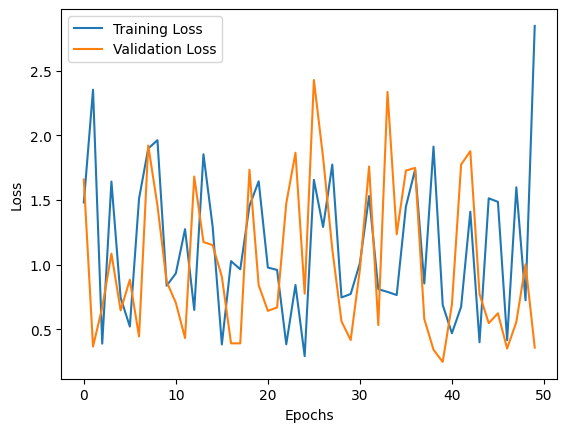

In [12]:
epochs = [epoch for epoch in range(50)]
plt.plot(epochs, train_losses, label = 'Training Loss')
plt.plot(epochs, val_losses, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
prediction_dataset = WeatherDataset()
week=prediction_dataset.date_generation('01_01_2024','08_01_2024')
imgs, xs =[],[]
for day in week:
    img, x = prediction_dataset[day]
    imgs.append(img)
    xs.append(x)
imgs = np.array(imgs)
xs = np.array(xs)
imgs = [torch.from_numpy(imgs).float()]
xs = [torch.from_numpy(xs).float()]
imgs = np.array(imgs)
xs = np.array(xs)
imgs = torch.from_numpy(imgs).float()
xs = torch.from_numpy(xs).float()

In [14]:
def predict(model, imgs, xs):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    imgs= imgs.to(device)
    xs = xs.to(device)
    outputs = model(imgs, xs)    
    return outputs

In [15]:
print(predict(model, imgs, xs))
print(dataset['08_01_2024'][1][3])

tensor([[0.0744]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(-0.2962, dtype=torch.float64)
